<a href="https://colab.research.google.com/github/deloragaskins/data_science_public/blob/learning_goals/independent_study/Chem_Ash_2_masked_token_simple_benzene_derivatives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Abstract

In this notebook, ChemBERTa is used to predict masked tokens of length 1 of the SMILES representation of benzene  using transformers. The type of token replaced affected wheter or not benzene could be correctly predicted by the model.The position of the mask was found to affect what type of additions occured. These observations are consitent with the synatax of SMILES and the limitation of one character replacements.  

## About ChemBERTA
Further details from [Reference](https://github.com/deepchem/deepchem/blob/ac2951baf5e2acccd0267ce5c84e2ba02473f368/examples/tutorials/Transfer_Learning_With_ChemBERTa_Transformers.ipynb) are quoted below. 
> The default tokenizer used by ChemBERTa, is a Byte-Pair-Encoder (BPE). It is a hybrid between character and word-level representations, which allows for the handling of large vocabularies in natural language corpora. Motivated by the intuition that rare and unknown words can often be decomposed into multiple known subwords, BPE finds the best word segmentation by iteratively and greedily merging frequent pairs of characters. Using the same pre-training procedure used by RoBERTa, a follow-up work of BERT, which masks 15% of the tokens, we mask 15% of the tokens in each SMILES string and assign a maximum sequence length of 256 characters.

> The model then learns to predict masked tokens consisting of atoms and functional groups, or specific groups of atoms within molecules which have their own characteristic properties. Through this, the model learns the relevant molecular context for transferable tasks, such as property prediction.

> ChemBERTa employs a bidirectional training context to learn context-aware representations of the PubChem 10M dataset, downloadable through MoleculeNet for self-supervised pre-training (link). Our variant of the BERT transformer uses 12 attention heads and 6 layers, resulting in 72 distinct attention mechanisms.

<!-- Now, to ensure our the ChemBERTa model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for benzene and simple derivatives. Using the Huggingface pipeline we initialized earlier we can fetch a list of the model's predictions. -->

#preamble


In [1]:
!pip install --pre deepchem
!pip install rdkit-pypi

#to access ClinTox_
# import MolNet dataloder from bert-loves-chemistry fork
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git
%cd /content/bert-loves-chemistry
!pwd
from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop

#to play with chemical structures
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Draw as ChemDraw
from rdkit.Chem.Draw import MolToImage

#for display
import matplotlib.pyplot as plt
from matplotlib import colors


     |████████████████████████████████| 610 kB 26.1 MB/s 
     |████████████████████████████████| 20.4 MB 1.2 MB/s 
Cloning into 'bert-loves-chemistry'...
remote: Enumerating objects: 1476, done.
remote: Counting objects: 100% (487/487), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 1476 (delta 316), reused 334 (delta 256), pack-reused 989
Receiving objects: 100% (1476/1476), 48.57 MiB | 21.54 MiB/s, done.
Resolving deltas: 100% (966/966), done.
/content/bert-loves-chemistry
/content/bert-loves-chemistry


In [2]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install transformers

from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from bertviz import head_view

import torch


Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1422, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 1422 (delta 142), reused 135 (delta 71), pack-reused 1203
Receiving objects: 100% (1422/1422), 213.85 MiB | 25.39 MiB/s, done.
Resolving deltas: 100% (905/905), done.
     |████████████████████████████████| 3.1 MB 25.2 MB/s 
     |████████████████████████████████| 596 kB 40.9 MB/s 
     |████████████████████████████████| 59 kB 8.2 MB/s 
     |████████████████████████████████| 895 kB 44.7 MB/s 
     |████████████████████████████████| 3.3 MB 39.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
def predict_n(sequence,n):
  input = tokenizer.encode(sequence, return_tensors="pt")
  mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

  token_logits = model(input)[0]
  mask_token_logits = token_logits[0, mask_token_index, :]
  top_n_tokens = torch.topk(mask_token_logits, n, dim=1).indices[0].tolist()
  #print(top_n_tokens)

  valid_mols_list=[]
  for token in top_n_tokens:
    smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
    #print (smi)
    smi_mol = Chem.MolFromSmiles(smi)
    if smi_mol is None: # if the model's token prediction isn't chemically feasible
      continue
    valid_mols_list.append(Chem.AddHs(smi_mol))
  return valid_mols_list

def addmask(molecule_str,mask_str,mask_start_pos,mask_end_pos):
  masked=''
  for counter0 in range(len(molecule_str)):
    if mask_len>0:
      if counter0 in range(mask_start_pos,mask_end_pos):
        masked+=''
      elif counter0 == mask_end_pos:
        masked+=mask_str
      else:
        masked+=molecule_str[counter0]
    else:
        masked+=molecule_str[counter0]
  #print(masked)
  return masked
    

## make predictions

Make predictions for the molecules that are generated when the mask is in the place of the Carbon atom, bonds, ring closures. 

In [4]:
#train the model and define the pipeline
model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/515 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/321M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/161k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/98.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [38]:
#Make valid predictions for single masked position 
molecule_str="C1=CC=CC=C1"
img_list=[]
mask_list=[]
replaced_list=[]
for counter1 in range(len(molecule_str)):
  mask_start_pos=counter1
  mask_end_pos=mask_start_pos
  mask_len=mask_end_pos-mask_start_pos+1
  mask_str='<mask>'

  smiles_mask=addmask(molecule_str,mask_str,mask_start_pos,mask_end_pos)
  replaced=molecule_str[mask_start_pos:mask_end_pos+1]
  sequence = smiles_mask.replace('<mask>',tokenizer.mask_token)
  n=5
  valid_mols_list=predict_n(sequence,n)
  #valid_mols_list.insert(0, Chem.AddHs(Chem.MolFromSmiles(smiles_org)))
  mask_list.append(smiles_mask)
  img_list.append(ChemDraw.MolsToGridImage(valid_mols_list,molsPerRow=5))
  replaced_list.append(replaced)

##results

Figure 1 is organized by masked character type. Column 1 shows the Carbon replacements, Column 2 shows the double bond replacements, Column 3 shows the replacements of the number 1 which indicate ring closure. For the double bond replacements and the ring closure, benzene was found sucessfully. 

Benzene is only sucessfuly found in the first 5 predictions for the first carbon when it is masked. The remainder of the carbons generate larger rings. A substution in the middle of the smiles representation requires at least three charters : '(',')' and 'X' where X is the atom being substitued.  However in the first position no parenthesises are required, and any valid characters for atoms will give a sucessful substitution. 

The more typical substitutions for benzene (Piperidine  and additional functional groups on benzene) are not observed. 



['C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1']


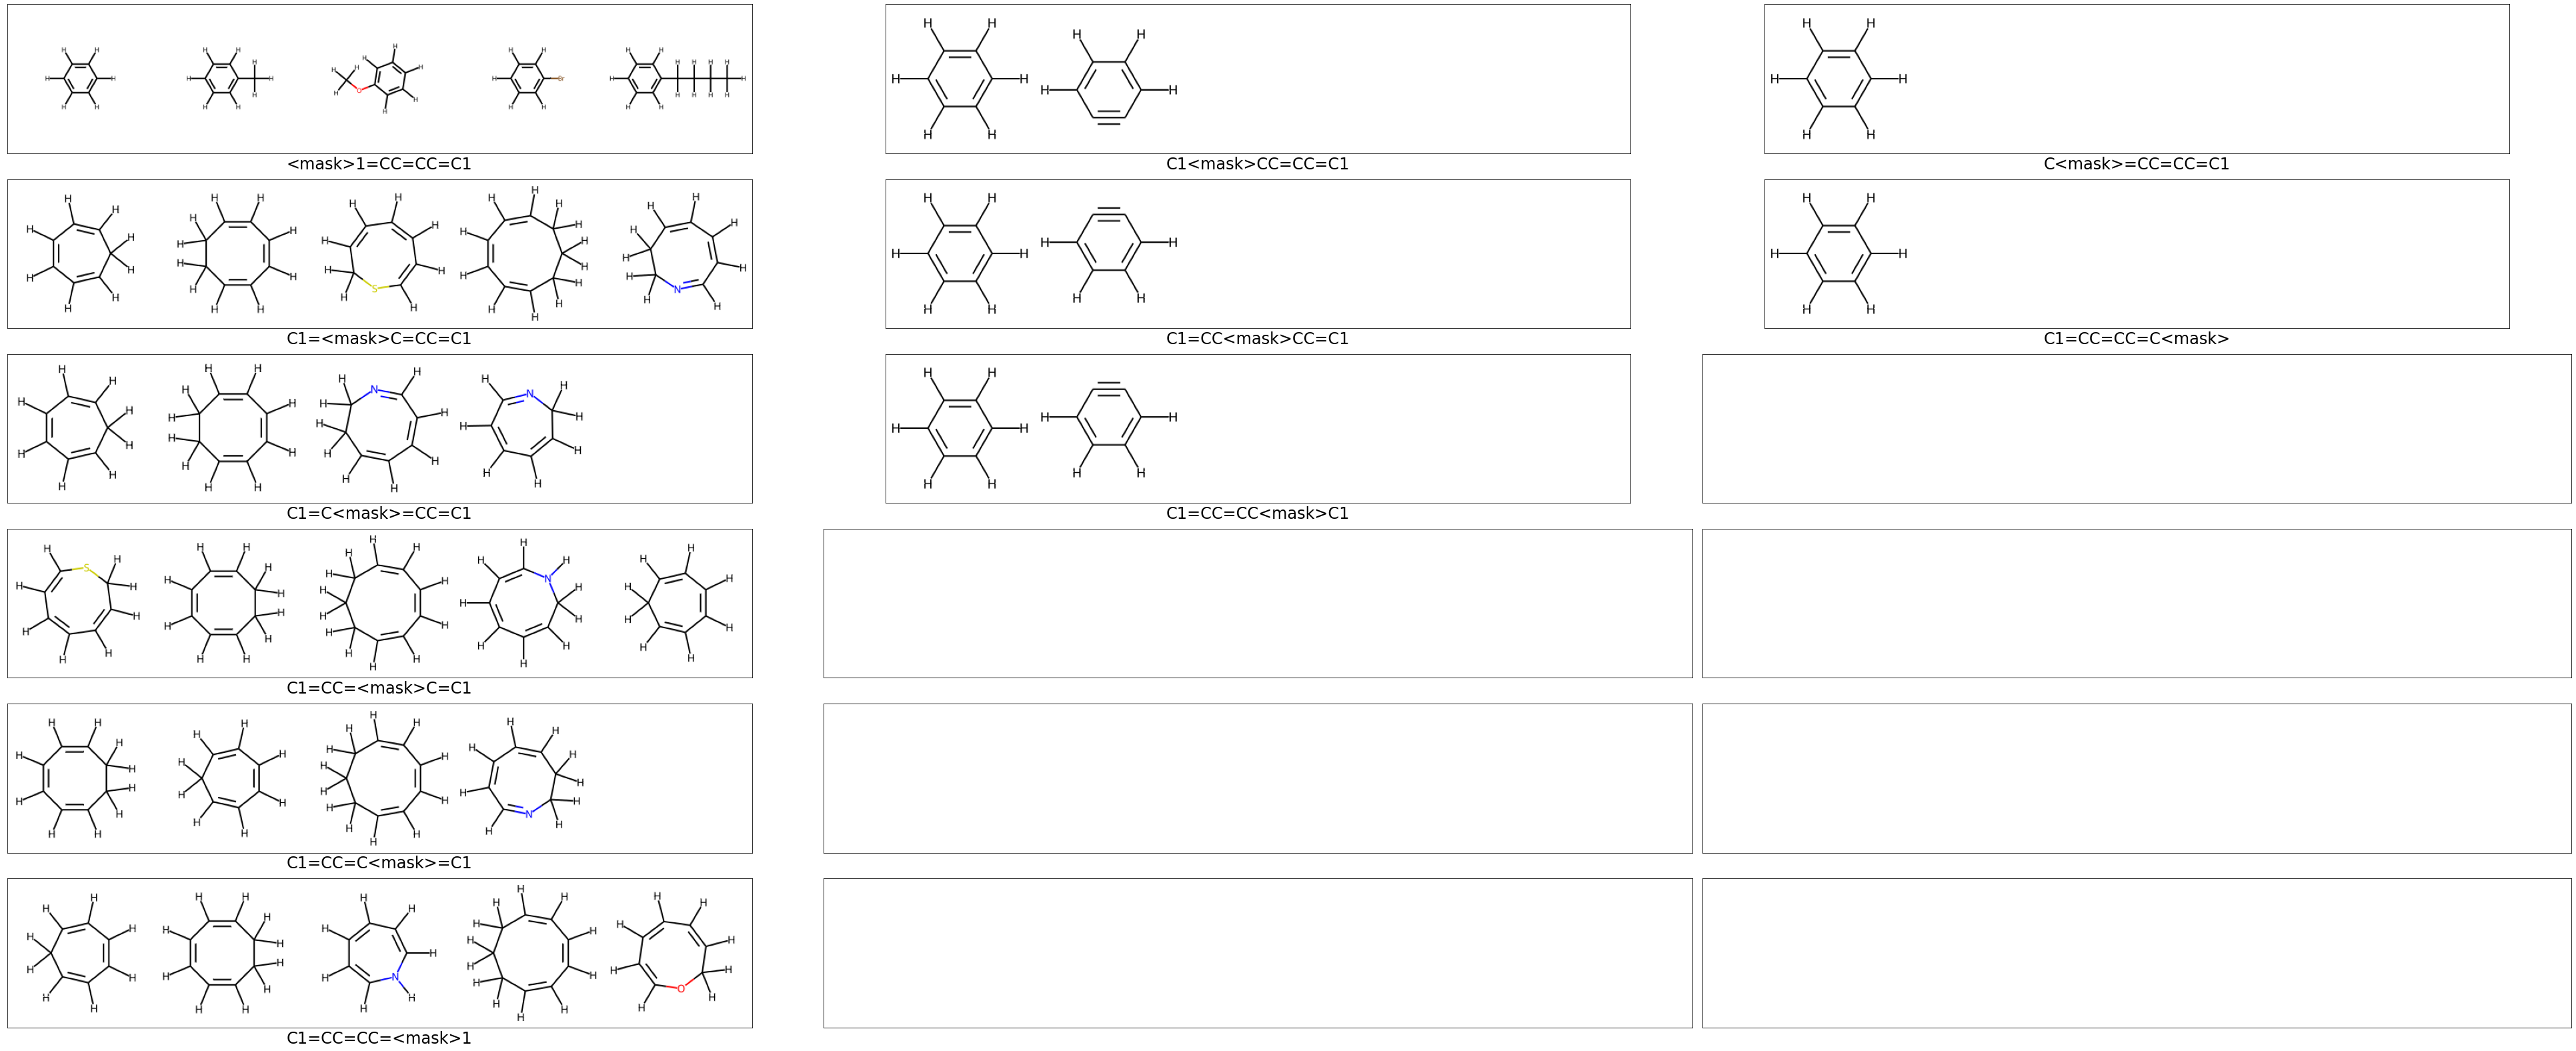

In [57]:
#########################################################################
#Display
sorted_list=[0,3,4,6,7,9]+[2,5,8]+[1,10]
reordered_list=[0,2,1,3,5,10,4,8,'blank',6,'blank','blank',7,'blank','blank',9,'blank','blank']

print(replaced_list)
length_peek=len(img_list)
size_adj_x=2*length_peek
size_adj_y=5*length_peek
Fig1=plt.figure(figsize=(size_adj_y,size_adj_x))

number_of_rows=6
number_of_columns=3
for counter0 in range(number_of_columns*number_of_rows):
  plt.subplot(number_of_rows,number_of_columns,counter0+1)
  if reordered_list[counter0] != 'blank':
    plt.imshow(img_list[reordered_list[counter0]])
    plt.xlabel(mask_list[reordered_list[counter0]], fontsize=24)
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()